# train, test loading

In [1]:
import pandas as pd

print('loading train...', flush=True, end='')

# x를 loading해서 (batch_size, step, channel)
input_path = '../DL_model/dataset/preprocess3/input3-2/'
x_train = np.load(input_path+'x_train.npz', allow_pickle=True)['arr_0']
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
x_val = np.load(input_path+'x_val.npz', allow_pickle=True)['arr_0']

y_train = np.load(input_path+'y_train.npz')['arr_0']
y_test = np.load(input_path+'y_test.npz')['arr_0']
y_val = np.load(input_path+'y_val.npz')['arr_0']
print('done', flush=True)

print('x_train shape:', x_train.shape)
print('x_test.shape:', x_test.shape)
print('x_val.shape:', x_val.shape)


loading train...done
x_train shape: (78513, 5000, 2)
x_test.shape: (9344, 5000, 2)
x_val.shape: (8707, 5000, 2)


## binary classification

In [2]:
# binary classification
y_train_bin = y_train >= 4
y_test_bin = y_test >= 4
y_val_bin = y_val >= 4

y_train_bin2 = y_train >=7
y_val_bin2 = y_val>=7
y_test_bin2 = y_test>=7

## multi-class classification (3 class)

In [20]:
print('train set: no pain {} ({:.2f}%), moderate pain {} ({:.2f}%), severe pain {} ({:.2f}%)'.format(dict_train['0'],dict_train['0']/(dict_train['0']+dict_train['1']+dict_train['2'])*100,dict_train['1'],dict_train['1']/(dict_train['0']+dict_train['1']+dict_train['2'])*100,dict_train['2'],dict_train['2']/(dict_train['0']+dict_train['1']+dict_train['2'])*100))
print('val set: no pain {} ({:.2f}%), moderate pain {} ({:.2f}%), severe pain {} ({:.2f}%)'.format(dict_val['0'],dict_val['0']/(dict_val['0']+dict_val['1']+dict_val['2'])*100,dict_val['1'],dict_val['1']/(dict_val['0']+dict_val['1']+dict_val['2'])*100,dict_val['2'],dict_val['2']/(dict_val['0']+dict_val['1']+dict_val['2'])*100))
print('test set: no pain {} ({:.2f}%), moderate pain {} ({:.2f}%), severe pain {} ({:.2f}%)'.format(dict_test['0'],dict_test['0']/(dict_test['0']+dict_test['1']+dict_test['2'])*100,dict_test['1'],dict_test['1']/(dict_test['0']+dict_test['1']+dict_test['2'])*100,dict_test['2'],dict_test['2']/(dict_test['0']+dict_test['1']+dict_test['2'])*100))


train set: no pain 30132 (38.38%), moderate pain 36114 (46.00%), severe pain 12267 (15.62%)
val set: no pain 3253 (37.36%), moderate pain 4185 (48.06%), severe pain 1269 (14.57%)
test set: no pain 3947 (42.24%), moderate pain 4015 (42.97%), severe pain 1382 (14.79%)


In [2]:
print('y_train의 평균: {:.4f}, y_test의 평균: {:.4f}'.format(np.mean(y_train_bin), np.mean(y_test_bin)))
print('y_val의 평균: {:.4f}'.format(np.mean(y_val_bin)))

y_train의 평균: 0.6065, y_test의 평균: 0.5790
y_val의 평균: 0.6111


In [3]:
# labels for y_train
y_train_class = []
for i in range(y_train.shape[0]):
    if y_train[i] <= 3.5:
        y_train_class.append((1,0,0))
    elif 3.5<y_train[i]<=6.5:
        y_train_class.append((0,1,0))
    else:
        y_train_class.append((0,0,1))
        
y_train_class = np.array(y_train_class, int)


# labels for y_val
y_val_class = []
for i in range(y_val.shape[0]):
    if y_val[i] <= 3.5:
        y_val_class.append((1,0,0))
    elif 3.5<y_val[i]<=6.5:
        y_val_class.append((0,1,0))
    else:
        y_val_class.append((0,0,1))
        
y_val_class = np.array(y_val_class, int)

# labels for y_test
y_test_class = []
hist_y_test = [0, 0, 0]
for i in range(y_test.shape[0]):
    if y_test[i] <= 3.5:
        y_test_class.append([1,0,0])
        hist_y_test[0]+=1
    elif 3.5<y_test[i]<=6.5:
        y_test_class.append([0,1,0])
        hist_y_test[1]+=1
    else:
        y_test_class.append([0,0,1])
        hist_y_test[2]+=1
        
y_test_class = np.array(y_test_class, int)
print('y_test class bins: ', hist_y_test)

y_test class bins:  [3947, 4015, 1382]


# GPU setting

## GPU memory 확장

In [3]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 4 Logical GPUs


# Model

## Sample weight

### NRS 각 class마다 weight

In [73]:
sample_weight = np.ones(shape=(len(y_train),))
for i in range(0,11):
    sample_weight[y_train==i] = len(y_train)/np.sum(y_train==i)
    
    
for i in range(0,11):
    print(len(y_train)/np.sum(y_train==i))

5.300276783906028
872.3666666666667
17.105228758169936
7.379734937494125
7.4047910968593795
4.210941271118262
11.4350422371104
14.285480349344978
13.854420328215987
83.79188900747064
470.1377245508982


### 2개의 class에 대한 sample_weight

In [12]:
# 2 class에 대한 sample weight
train_w_samp2 = np.ones(shape=(len(y_train),))
train_w_samp2[y_train_bin==0]= len(y_train) / np.sum(y_train_bin)
train_w_samp2[y_train_bin!=0]= len(y_train) / np.sum(~y_train_bin)

train_w_samp2_2 = np.ones(shape=(len(y_train),))
train_w_samp2_2[y_train_bin==0]= len(y_train) / np.sum(y_train_bin2)
train_w_samp2_2[y_train_bin!=0]= len(y_train) / np.sum(~y_train_bin2)

print('sample weight for no pain: {:.2f}, moderate pain: {:.2f}'
      .format(len(y_train) / np.sum(y_train_bin), len(y_train) / np.sum(~y_train_bin)))
print('sample weight for no pain: {:.2f}, severe pain: {:.2f}'
      .format(len(y_train) / np.sum(y_train_bin2), len(y_train) / np.sum(~y_train_bin2)))

# 2 class에 대한 sample weight
val_w_samp2 = np.ones(shape=(len(y_val),))
val_w_samp2[y_val_bin==0]= len(y_val) / np.sum(y_val_bin)
val_w_samp2[y_val_bin!=0]= len(y_val) / np.sum(~y_val_bin)

val_w_samp2_2 = np.ones(shape=(len(y_val),))
val_w_samp2_2[y_val_bin==0]= len(y_val) / np.sum(y_val_bin2)
val_w_samp2_2[y_val_bin!=0]= len(y_val) / np.sum(~y_val_bin2)

print('sample weight for no pain: {:.2f}, moderate pain: {:.2f}'
      .format(len(y_val) / np.sum(y_val_bin), len(y_val) / np.sum(~y_val_bin)))
print('sample weight for no pain: {:.2f}, severe pain: {:.2f}'
      .format(len(y_val) / np.sum(y_val_bin2), len(y_val) / np.sum(~y_val_bin2)))

# 2 class에 대한 sample weight
test_w_samp2 = np.ones(shape=(len(y_test),))
test_w_samp2[y_test_bin==0]= len(y_test) / np.sum(y_test_bin)
test_w_samp2[y_test_bin!=0]= len(y_test) / np.sum(~y_test_bin)

test_w_samp2_2 = np.ones(shape=(len(y_test),))
test_w_samp2_2[y_test_bin==0]= len(y_test) / np.sum(y_test_bin2)
test_w_samp2_2[y_test_bin!=0]= len(y_test) / np.sum(~y_test_bin2)

print('sample weight for no pain: {:.2f}, moderate pain: {:.2f}'
      .format(len(y_test) / np.sum(y_test_bin), len(y_test) / np.sum(~y_test_bin)))
print('sample weight for no pain: {:.2f}, severe pain: {:.2f}'
      .format(len(y_test) / np.sum(y_test_bin2), len(y_test) / np.sum(~y_test_bin2)))

NameError: name 'y_train_bin2' is not defined

### 3개의 class에 대해 sample_weight

In [4]:
# 3 class에 대한 sample weight
train_w_samp3 = np.ones(shape=(len(y_train),))

train_w_samp3[y_train<4]= len(y_train)/np.sum(y_train<4)
train_w_samp3[(y_train>=4)&(y_train<7)]= len(y_train)/np.sum((4<=y_train)&(y_train<7))
train_w_samp3[y_train>=7]= len(y_train)/np.sum(y_train>=7)


print('sample weight for class 1: {:.2f}, class 2: {:.2f}, class 3: {:.2f}'
      .format(len(y_train)/np.sum(y_train<4),len(y_train)/np.sum((y_train>=4)&(y_train<7)),len(y_train)/np.sum(y_train>=7)))

# 3 class에 대한 sample weight
val_w_samp3 = np.ones(shape=(len(y_val),))

val_w_samp3[y_val<4]= len(y_val)/np.sum(y_val<4)
val_w_samp3[(y_val>=4)&(y_val<7)]= len(y_val)/np.sum((4<=y_val)&(y_val<7))
val_w_samp3[y_val>=7]= len(y_val)/np.sum(y_val>=7)


print('sample weight for class 1: {:.2f}, class 2: {:.2f}, class 3: {:.2f}'
      .format(len(y_val)/np.sum(y_val<4),len(y_val)/np.sum((y_val>=4)&(y_val<7)),len(y_val)/np.sum(y_val>=7)))

# 3 class에 대한 sample weight
test_w_samp3 = np.ones(shape=(len(y_test),))

test_w_samp3[y_test<4]= len(y_test)/np.sum(y_test<4)
test_w_samp3[(y_test>=4)&(y_test<7)]= len(y_test)/np.sum((4<=y_test)&(y_test<7))
test_w_samp3[y_test>=7]= len(y_test)/np.sum(y_test>=7)


print('sample weight for class 1: {:.2f}, class 2: {:.2f}, class 3: {:.2f}'
      .format(len(y_test)/np.sum(y_test<4),len(y_test)/np.sum((y_test>=4)&(y_test<7)),len(y_test)/np.sum(y_test>=7)))

sample weight for class 1: 2.61, class 2: 2.17, class 3: 6.40
sample weight for class 1: 2.68, class 2: 2.08, class 3: 6.86
sample weight for class 1: 2.37, class 2: 2.33, class 3: 6.76


## Training

### 1D-CNN

In [29]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.optimizers import Adam as Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout, Activation
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, LeakyReLU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import os, pickle
from keras import backend as K
from keras import regularizers
from keras.initializers import he_normal, GlorotNormal
import tensorflow_addons as tfa

# hyperparamters
num_nodes = [64, 64, 64, 256] #, 64, 64, 64]
kernel_size = 3
pool_size = 2
BATCH_SIZE = 1024
dense_node = 0
dropout_rate = 0.3
dropout_cnn = 0.3
dropout_fc = 0.3
learning_rate = 0.001


# initializer & regularizer
k_init = he_normal(seed=None)
#k_init = GlorotNormal(seed=None) # Xavier normal initializer
#k_init = None
b_init = None
k_l2 = 0
#k_reg = regularizers.l2(l2=k_l2)
k_reg = None
b_reg = None


testname = '-'.join([str(num_node) for num_node in num_nodes])
print(testname)


# 출력 폴더를 생성
model_name = 'model_bin_sampleweight_'
for num_node in num_nodes:
    model_name += 'conv{}_'.format(num_node)
model_name += 'filter{}x2_tanh_bn_maxpool{}_globalmaxpool_dropout{}_dense{}_dropout{}_batch{}_lr_{}_kinit_kreg{}'.format(kernel_size, pool_size, dropout_cnn, dense_node, dropout_fc, BATCH_SIZE, learning_rate, k_l2)

#model_name = 'model_reg_{}_{}_{}_size{}_relu_bn_maxpool{}_globalmaxpool_dense32_dropout{}_batch{}_learning_rate{}'.format(num_nodes[0], num_nodes[1], num_nodes[2], kernel_size, pool_size, dropout_rate, BATCH_SIZE, learning_rate)
save_path = "output/preprocess3/input3-2_PPG+ECG/1D_CNN_"+model_name

if not os.path.exists(save_path):
    os.mkdir(save_path)
weight_path = save_path + "/weights.hdf5"


# GPU 설정
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])
with strategy.scope():
    
    # build a model
    model = Sequential()
    for num_node in num_nodes:
        model.add(Conv1D(filters=num_node, kernel_size=kernel_size, padding='same', kernel_initializer=k_init,bias_initializer =b_init , kernel_regularizer=k_reg, bias_regularizer=b_reg))
        model.add(Conv1D(filters=num_node, kernel_size=kernel_size, padding='same', kernel_initializer=k_init,bias_initializer =b_init , kernel_regularizer=k_reg, bias_regularizer=b_reg))
        #model.add(LeakyReLU(alpha=0.1))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=pool_size))
    #model.add(BatchNormalization())    
    model.add(GlobalMaxPool1D())
    #model.add(Flatten())
    model.add(Dropout(dropout_cnn))
    #model.add(Activation('sigmoid'))
    #model.add(Dropout(dropout_rate))
    if dense_node != 0:
        model.add(Dense(dense_node, activation='tanh', kernel_initializer=k_init, kernel_regularizer=k_reg))
        model.add(Dropout(dropout_fc))
    model.add(Dense(1, activation='sigmoid'))

    
    # model 학습 설정
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=["acc", tf.keras.metrics.AUC()])
    hist = model.fit(x_train, y_train_bin, validation_data = (x_val, y_val_bin, val_w_samp), sample_weight=train_w_samp, epochs=100, batch_size=BATCH_SIZE, #class_weight={0:1, 1:3}, 
                            callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                                        EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])

    #tf.keras.backend.clear_session()

model.load_weights(weight_path)
    
# 모델의 아키텍처 및 구조 저장
open(save_path + "/model.json", "wt").write(model.to_json())


# 전체 test 샘플을 한번에 예측
y_pred = model.predict(x_test).flatten() # binary는 flatten

# 결과를 저장
#np.savetxt(save_path+'/pred_y.txt', y_pred)


# 모델의 history log 저장 - binary classification
for key in hist.history.keys():
    if 'auc' in key and not 'val' in key:
        auc_key = key
#pickle.dump((hist.history['loss'], hist.history['val_loss'], hist.history['accuracy'], hist.history['val_accuracy'], hist.history[auc], hist.history['val_'+auc]), open(save_path+'/history', 'wb'))

# 모델의 history log 저장 - regression
pickle.dump((hist.history['loss'], hist.history['val_loss'], hist.history['acc'], hist.history['val_acc'], hist.history[auc_key], hist.history['val_'+auc_key]), open(save_path+'/history', 'wb'))


64-64-64-256
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Epoch 1/100
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
77/77 [==============================] - ETA: 0s - loss: 3.0012 - acc: 0.5695 - auc_4: 0.5338
Epoch 00001: val_loss improved from inf to 3.14056, saving model to output/preprocess3/input3-2_PPG+ECG/1D_CNN_model_bin_sampleweight_conv64_conv64_conv64_conv256_filter3x2_tanh_bn_maxpool2_globalmaxpool_dropout0.3_dense0_dropout0.3_batch1024_lr_0.001_kinit_kreg0/weights.hdf5
77/77 [==============================] - 21s 274ms/step - loss: 3.0012 - acc: 0.5695 - auc_4: 0.5338 - val_loss: 3.1406 - val_acc: 0.6286 - val_auc_4: 0.6227
Epoch 2/100
77/77 [==============================] - ETA: 0s - loss: 2.2038 - acc: 0.6100 - auc_4: 0.5944
Epoch 00002: val_lo

### 5 layers with options

In [11]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.optimizers import Adam as Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout, Activation
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, LeakyReLU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import os, pickle
from keras import backend as K
from keras import regularizers
from keras.initializers import he_normal, GlorotNormal

#error_batch=512,c1=256,c2=32,c3=32,c4=64,c5=128,filt1=5,filt2=3,filt3=7,filt4=9,filt5=5,str1=4,str2=4,str3=3,str4=4,
#str5=4,conv_double=False,globalpool=ave,dropout=0.1,dnodes=16,dropout=0

# test_setting
num_l1, num_l2, num_l3, num_l4, kernel_l1, kernel_l2, kernel_l3, kernel_l4 = 256,32,32,64,5,3,7,9
dense_node, dropout_cnn, dropout_fc, globalpool_opt, batch_size, conv_double = 16,0.1,0,'ave',512,False
stride_l1, stride_l2, stride_l3, stride_l4, stride_l5, num_l5, kernel_l5 = 4,4,3,4,4,128,5
pool_size=2
learning_rate=0.001

# total conv layers of the model
n_conv = 5

if n_conv==2:
    num_l3,kernel_l3,stride_l3 = 0,0,0
    num_l4,kernel_l4,stride_l4 = 0,0,0
    num_l5,kernel_l5,stride_l5 = 0,0,0

if n_conv==3:
    num_l4,kernel_l4,stride_l4 = 0,0,0
    num_l5,kernel_l5,stride_l5 = 0,0,0



# GPU 설정
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])
with strategy.scope():

    model = Sequential()

    act='relu'

    # c1 layer
    if conv_double:
        model.add(Conv1D(filters=num_l1, kernel_size=kernel_l1, strides=stride_l1, padding='same'))
    model.add(Conv1D(filters=num_l1, kernel_size=kernel_l1, strides=stride_l1, padding='same', activation=act))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=pool_size))


    # c2 layer
    if num_l1 == 512:
        model.add(Conv1D(filters=128,kernel_size=1,padding='same'))
    if conv_double:
        model.add(Conv1D(filters=num_l2, kernel_size=kernel_l2, strides=stride_l2, padding='same'))
    model.add(Conv1D(filters=num_l2, kernel_size=kernel_l2, strides=stride_l2, padding='same', activation=act))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=pool_size))


    # c3 layer
    if n_conv>2:
        if num_l2 == 512:
            model.add(Conv1D(filters=128,kernel_size=1,padding='same'))
        if conv_double:
            model.add(Conv1D(filters=num_l3, kernel_size=kernel_l3, strides=stride_l3, padding='same'))
        model.add(Conv1D(filters=num_l3, kernel_size=kernel_l3, strides=stride_l3, padding='same', activation=act))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=pool_size))


    # c4 layer
    if n_conv>3:
        if num_l3 == 512:
            model.add(Conv1D(filters=128,kernel_size=1,padding='same'))
        if conv_double:
            model.add(Conv1D(filters=num_l4, kernel_size=kernel_l4, strides=stride_l4, padding='same'))
        model.add(Conv1D(filters=num_l4, kernel_size=kernel_l4, strides=stride_l4, padding='same', activation=act))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=pool_size))

    # c5 layer
    if n_conv>4:
        if num_l4 == 512:
            model.add(Conv1D(filters=128,kernel_size=1,padding='same'))
        if conv_double:
            model.add(Conv1D(filters=num_l5, kernel_size=kernel_l5, strides=stride_l5, padding='same'))
        model.add(Conv1D(filters=num_l5, kernel_size=kernel_l5, strides=stride_l5,padding='same', activation=act))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=pool_size))            



    # global이냐 flatten이냐는 따로 모델 나눠야 할듯
    if globalpool_opt == 'max':
        model.add(GlobalMaxPool1D())
    elif globalpool_opt == 'ave':
        model.add(GlobalAveragePooling1D())


    if dense_node != 0:
        model.add(Dropout(dropout_cnn))
        model.add(Dense(dense_node, activation='tanh'))
    model.add(Dropout(dropout_fc))
    model.add(Dense(1, activation='sigmoid'))

    
    # model 학습 설정
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=["acc", tf.keras.metrics.AUC()])
    hist = model.fit(x_train, y_train_bin, validation_data = (x_val, y_val_bin, val_w_samp3), sample_weight=train_w_samp3, epochs=100, batch_size=batch_size, #class_weight={0:1, 1:3}, 
                            callbacks=[ModelCheckpoint(monitor='val_loss', filepath=None, verbose=1, save_best_only=True),
                                        EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/100
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:Error reported to Coordinator: Negative dimension size caused by subtracting 2 from 1 for '{{node sequential_4/max_pooling1d_19/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 2, 1, 1], padding="VALID", strides=[1, 2, 1, 1]](sequential_4/max_pooling1d_19/ExpandDims)' with input shapes: [?,1,1,128].
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 1812, in _create_c_op
    c_op = pywrap_tf_session.TF_FinishOperation(op_desc)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Negative dimension size caused by subtracting 2 from 1 for '{{node sequential_4/max_pooling1d_19/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 2, 1, 1], padding="VALID", strides=[1, 2, 1, 1]](s

ValueError: in user code:

    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/mirrored_strategy.py:585 _call_for_each_replica
        self._container_strategy(), fn, args, kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/mirrored_run.py:96 call_for_each_replica
        return _call_for_each_replica(strategy, fn, args, kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/mirrored_run.py:237 _call_for_each_replica
        coord.join(threads)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/coordinator.py:389 join
        six.reraise(*self._exc_info_to_raise)
    /usr/local/lib/python3.6/dist-packages/six.py:703 reraise
        raise value
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/coordinator.py:297 stop_on_exception
        yield
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/mirrored_run.py:323 run
        self.main_result = self.main_fn(*self.main_args, **self.main_kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:386 call
        outputs = layer(inputs, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/pooling.py:80 call
        data_format=self.data_format)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:5519 pool2d
        x, pool_size, strides, padding=padding, data_format=tf_data_format)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_ops.py:4520 max_pool
        name=name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_nn_ops.py:5269 max_pool
        data_format=data_format, name=name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/func_graph.py:593 _create_op_internal
        compute_device)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py:3485 _create_op_internal
        op_def=op_def)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py:1975 __init__
        control_input_ops, op_def)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Negative dimension size caused by subtracting 2 from 1 for '{{node sequential_4/max_pooling1d_19/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 2, 1, 1], padding="VALID", strides=[1, 2, 1, 1]](sequential_4/max_pooling1d_19/ExpandDims)' with input shapes: [?,1,1,128].


### Inception

In [13]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.optimizers import Adam as Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout, Activation
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, AveragePooling1D, Input, concatenate, add, LSTM, Average
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import os, pickle
from keras import backend as K


def inception(inp, nfilters=32):
    # 각각은 길이가 줄어들지 않는다

    # 1 conv
    c1 = Conv1D(filters=nfilters, kernel_size=1, kernel_initializer='glorot_uniform', padding='same', activation='relu')(inp)

    # 3 reduce
    c2 = Conv1D(filters=nfilters, kernel_size=1, kernel_initializer='glorot_uniform', padding='same', activation='relu')(inp)
    # 3 conv
    c2 = Conv1D(filters=nfilters, kernel_size=3, kernel_initializer='glorot_uniform', padding='same', activation='relu')(c2)

    # 5 reduce
    c3 = Conv1D(filters=nfilters, kernel_size=1, kernel_initializer='glorot_uniform', padding='same', activation='relu')(inp)
    # 5 conv
    c3 = Conv1D(filters=nfilters, kernel_size=5, kernel_initializer='glorot_uniform', padding='same', activation='relu')(c3)

    # pooling
    m1 = MaxPooling1D(pool_size=3, strides=1, padding='same')(inp)
    # pooling proj
    m1 = Conv1D(filters=nfilters, kernel_size=1, kernel_initializer='glorot_uniform', padding='same', activation='relu')(m1)

    return concatenate([c1, c2, c3, m1], axis=-1)


def inception2(inp, nfilters=32):
    # 각각은 길이가 줄어들지 않는다

    # 3 conv
    c1 = Conv1D(filters=nfilters, kernel_size=3, strides=1, kernel_initializer='glorot_uniform', padding='same', activation='relu')(inp)

    # 5 conv 
    c2 = Conv1D(filters=nfilters, kernel_size=5, kernel_initializer='glorot_uniform', padding='same', activation='relu')(inp)

    # 7 conv
    c3 = Conv1D(filters=nfilters, kernel_size=7, kernel_initializer='glorot_uniform', padding='same', activation='relu')(inp)

    # 15 conv
    c4 = Conv1D(filters=nfilters, kernel_size=15, kernel_initializer='glorot_uniform', padding='same', activation='relu')(inp)
    
    
    # pooling
    m1 = MaxPooling1D(pool_size=3, strides=1, padding='same')(inp)
    # pooling proj
    m1 = Conv1D(filters=nfilters, kernel_size=1, kernel_initializer='glorot_uniform', padding='same', activation='relu')(m1)

    return concatenate([c1, c2, c3, c4, m1], axis=-1)



In [22]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.optimizers import Adam as Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout, Activation
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, AveragePooling1D, Input, concatenate, add, LSTM, Average
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import os, pickle
from keras import backend as K
import tensorflow_addons as tfa


# learning related hyperparamters
BATCH_SIZE = 512
learning_rate = 0.001
# AdamW setting
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
    [10000, 15000], [1e-0, 1e-1, 1e-2])
# lr and wd can be a function or a tensor
lr = 1e-1 * schedule(step)
wd = lambda: 1e-4 * schedule(step)


# inception paramters
ngpu = 2
nfilters=32
nlayer=2
conv1 = 0
dense = 0
dropout1 = 0.2
dropout2 = 0.2
kernel1 = 3
kernel2 = 3
simple = True

# 출력 폴더를 생성
model_name = 'Inception_model_bin_sampleweight_simple{}_batch{}_conv{}_k{}x2_nfilter{}_k{}x2_nlayer{}_drop{}_dense{}_drop{}'.format(simple, BATCH_SIZE, conv1,kernel1,nfilters,kernel2,nlayer,dropout1,dense,dropout2)
#model_name = 'Inception2_model_bin_sampleweight_simple{}_batch{}_conv3_5_7_15_nfilter{}_nlayer{}_drop{}_dense{}_drop{}'.format(simple, BATCH_SIZE, nfilters,kernel2,nlayer,dropout1,dense,dropout2)


save_path = "output/preprocess3/input3-2_PPG+ECG/"+model_name
if not os.path.exists(save_path):
    os.mkdir(save_path)
weight_path = save_path + "/weights.hdf5"



# GPU 설정
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])
with strategy.scope():
    
    #inp_fnn = Input(shape=(x_train[0].shape[1],))
    inp_cnn = Input(shape=(x_train.shape[1], x_train.shape[2]))

    #out_fnn = inp_fnn
    #out_fnn = Dense(256,  activation='relu')(out_fnn)

    out_cnn = inp_cnn
    
    if not simple:
        if conv1 != 0:
            out_cnn = Conv1D(filters=conv1, kernel_size=kernel1, strides=1, padding='same')(out_cnn)
            out_cnn = Conv1D(filters=conv1, kernel_size=kernel1, strides=2, padding='same')(out_cnn)
            #out_cnn = Conv1D(filters=conv1, kernel_size=kernel1, padding='same')(out_cnn)
            #out_cnn = Conv1D(filters=conv1, kernel_size=kernel_size, padding='same', activation='relu')(out_cnn)
            out_cnn = Activation('relu')(out_cnn)
            out_cnn = MaxPooling1D(pool_size=3, strides=2)(out_cnn)
            out_cnn = BatchNormalization()(out_cnn)

        
        out_cnn = Conv1D(filters=nfilters*4, kernel_size=kernel2, padding='same')(out_cnn)
        out_cnn = Conv1D(filters=nfilters*4, kernel_size=kernel2, padding='same')(out_cnn)
        out_cnn = Activation('relu')(out_cnn)
        out_cnn = MaxPooling1D(pool_size=3, strides=2)(out_cnn)
        out_cnn = BatchNormalization()(out_cnn)
    
    for ilayer in range(nlayer):
        #inp_blk = out_cnn
        out_cnn = inception(out_cnn, nfilters=nfilters)
        #out_cnn = Conv1D(filters=64, kernel_size=1, padding='same')(out_cnn)
        #out_cnn = add([out_cnn, inp_blk])
        #out_cnn = AveragePooling1D(pool_size=2)(out_cnn)
    out_cnn = GlobalAveragePooling1D()(out_cnn)
    out_cnn = Dropout(dropout1)(out_cnn)
    #out = concatenate([out_cnn, out_fnn])
    out = out_cnn
    #out = Dense(256,  activation='relu')(out)
    
    if dense != 0:
        out = Dense(dense,  activation='tanh')(out)
        out = Dropout(dropout2)(out)
    out = Dense(1, activation='sigmoid')(out)

    model = Model(inputs=[inp_cnn], outputs=[out])
    
    # model 학습 설정
    #optimizer=tfa.optimizers.AdamW(lr=learning_rate, weight_decay=wd)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=["acc", tf.keras.metrics.AUC()])
    hist = model.fit(x_train, y_train_bin, validation_data = (x_val, y_val_bin, val_w_samp3), sample_weight=train_w_samp3, epochs=100, batch_size=BATCH_SIZE, #class_weight={0:1, 1:3}, 
                            callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                                        EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])

    #tf.keras.backend.clear_session()

model.load_weights(weight_path)
    
# 모델의 아키텍처 및 구조 저장
open(save_path + "/model.json", "wt").write(model.to_json())


# 전체 test 샘플을 한번에 예측
y_pred = model.predict(x_test).flatten() # binary는 flatten

# 결과를 저장
#np.savetxt(save_path+'/pred_y.txt', y_pred)


# 모델의 history log 저장 - binary classification
for key in hist.history.keys():
    if 'auc' in key and not 'val' in key:
        auc_key = key
#pickle.dump((hist.history['loss'], hist.history['val_loss'], hist.history['accuracy'], hist.history['val_accuracy'], hist.history[auc], hist.history['val_'+auc]), open(save_path+'/history', 'wb'))

# 모델의 history log 저장 - regression
pickle.dump((hist.history['loss'], hist.history['val_loss'], hist.history['acc'], hist.history['val_acc'], hist.history[auc_key], hist.history['val_'+auc_key]), open(save_path+'/history', 'wb'))


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/100
154/154 [==============================] - ETA: 0s - loss: 1.9526 - acc: 0.6091 - auc_7: 0.5204
Epoch 00001: val_loss improved from inf to 1.89822, saving model to output/preprocess3/input3-2_PPG+ECG/Inception_model_bin_sampleweight_simpleTrue_batch512_conv0_k3x2_nfilter32_k3x2_nlayer2_drop0.2_dense0_drop0.2/weights.hdf5
154/154 [==============================] - 50s 325ms/step - loss: 1.9526 - acc: 0.6091 - auc_7: 0.5204 - val_loss: 1.8982 - val_acc: 0.6264 - val_auc_7: 0.5446
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 1.8814 - acc: 0.6160 - auc_7: 0.5749
Epoch 00002: val_loss did not improve from 1.89822
154/154 [==============================] - 44s 286ms/step - loss: 1.8814 - acc: 0.6160 - auc_7: 0.5749 - val_loss: 1.9005 - val_acc: 0.6204 - val_auc_7: 0.5648
Epoch 3/100
154/154 [==============================] - ETA: 0s - loss: 1.8216 - acc:

154/154 [==============================] - ETA: 0s - loss: 1.3018 - acc: 0.7888 - auc_7: 0.8056
Epoch 00040: val_loss improved from 1.42020 to 1.39987, saving model to output/preprocess3/input3-2_PPG+ECG/Inception_model_bin_sampleweight_simpleTrue_batch512_conv0_k3x2_nfilter32_k3x2_nlayer2_drop0.2_dense0_drop0.2/weights.hdf5
154/154 [==============================] - 47s 307ms/step - loss: 1.3018 - acc: 0.7888 - auc_7: 0.8056 - val_loss: 1.3999 - val_acc: 0.7883 - val_auc_7: 0.7497
Epoch 41/100
154/154 [==============================] - ETA: 0s - loss: 1.2869 - acc: 0.7914 - auc_7: 0.8089
Epoch 00041: val_loss improved from 1.39987 to 1.39284, saving model to output/preprocess3/input3-2_PPG+ECG/Inception_model_bin_sampleweight_simpleTrue_batch512_conv0_k3x2_nfilter32_k3x2_nlayer2_drop0.2_dense0_drop0.2/weights.hdf5
154/154 [==============================] - 47s 307ms/step - loss: 1.2869 - acc: 0.7914 - auc_7: 0.8089 - val_loss: 1.3928 - val_acc: 0.7848 - val_auc_7: 0.7515
Epoch 42/100


## Model Evaluation

###  AUROC, AUPRC (sample weighted)

test set accuracy:0.78
test set AUROC: 0.7452569123714586
test set AUPRC: 0.8243459367850006


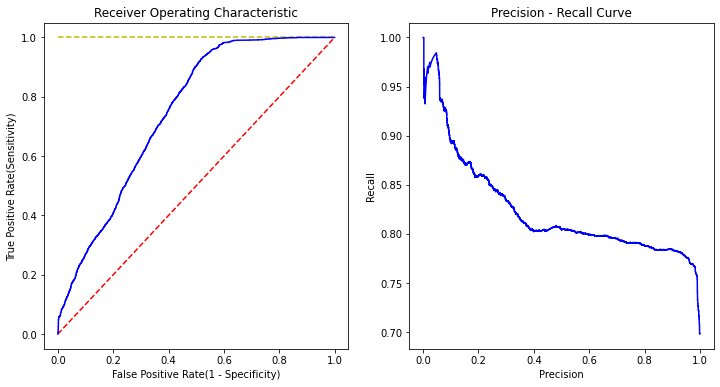

In [23]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt

### Classification
# Model Accuracy of test set
#model_y = y_pred>=0.5
#acc_val = np.mean(model_y==y_test_bin)
acc = metrics.Accuracy()
acc.update_state(y_pred>=0.5, y_test_bin, sample_weight=test_w_samp3)
acc_val = acc.result().numpy()
print('test set accuracy:{:.2f}'.format(acc_val))


# moderate pain
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_bin, y_pred, sample_weight = test_w_samp3)
precision, recall, _ = precision_recall_curve(y_test_bin, y_pred, sample_weight = test_w_samp3)
roc_auc = auc(false_positive_rate, true_positive_rate)
prc_auc = auc(recall, precision)
print('test set AUROC:', roc_auc)
print('test set AUPRC:', prc_auc)


# Adding evaluation results to file name
test_path = 'output/preprocess3/input3-2_PPG+ECG/auroc{:.4f}_auprc{:.4f}_{}acc{:.2f}'.format(roc_auc,prc_auc,model_name,acc_val)
os.rename(save_path, test_path)

# Plotting ROC, PRC
fig = plt.figure(figsize=(12,6))

# ax1: auroc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Receiver Operating Characteristic')
ax1.set_xlabel("False Positive Rate(1 - Specificity)")
ax1.set_ylabel('True Positive Rate(Sensitivity)')
ax1.plot([0,1],[1,1],'y--')
ax1.plot([0,1],[0,1],'r--')
ax1.plot(false_positive_rate, true_positive_rate, 'b', label='moderate pain (AUC = %0.4f)'% roc_auc)

# ax2: auprc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Precision - Recall Curve')
ax2.set_xlabel("Precision")
ax2.set_ylabel('Recall')
ax2.plot(recall, precision, 'b', label='moderate pain (AUC = %0.4f)'% prc_auc)

plt.savefig(test_path + '/roc_prc.png', bbox_inches="tight", pad_inches=0.5)


### Confusion matrix

In [16]:
import itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(3,3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.0f}'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

optimal thval: 0.5818

auroc:0.7448,  auprc:0.8243
Confusion matrix, without normalization
[[1982 1965]
 [ 388 5009]]


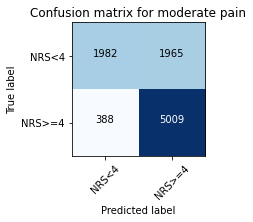

In [17]:
from sklearn.metrics import confusion_matrix, roc_curve


# calculate optimal threshold that minimize 'sensitivity(TPR) + specificity(1-FPR)''
fpr, tpr, thvals = roc_curve(y_test_bin, y_pred)
optimal_idx = np.argmax(tpr-fpr)
thval = thvals[optimal_idx]
print('optimal thval: {:.4f}'.format(thval))
                             
#precision1, recall1, _ = precision_recall_curve(y_test_pacu_bin, y_pred)

# confusion matrix
cnf_matrix = confusion_matrix(y_test_bin, y_pred>=thval)
np.set_printoptions(precision=2)
class_names = ['NRS<4','NRS>=4']

print('\nauroc:{:.4f},  auprc:{:.4f}'.format(roc_auc, prc_auc))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False, title='Confusion matrix for moderate pain')

## Model history plot
- training curve

model: Inception_model_bin_sampleweight_simpleTrue_batch512_conv0_k3x2_nfilter32_k3x2_nlayer2_drop0.2_dense0_drop0.2


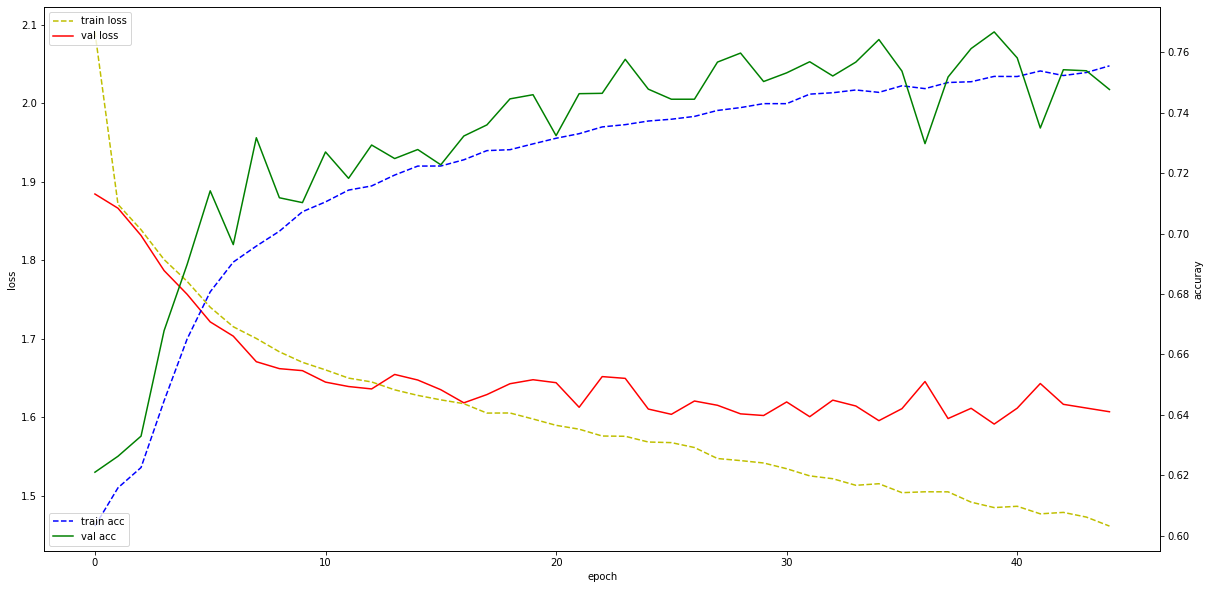

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt


print('model:', model_name)


fig, loss_ax = plt.subplots(figsize=(20,10))

#x-axis는 공유하지만 y-axis는 공유x
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', linestyle='dashed', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

#acc_ax.plot(hist.history['mean_absolute_error'], 'b', linestyle='dashed',label='train mae')
#acc_ax.plot(hist.history['val_mean_absolute_error'], 'g', label='val mae')
acc_ax.plot(hist.history['acc'], 'b', linestyle='dashed',label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
#acc_ax.set_ylim(0.2,1.0)
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
test_result = model.evaluate(x=x_test, y=y_test_bin, batch_size=512, verbose=1, sample_weight=None, steps=None, callbacks=None)

## Model summary

In [19]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 5000, 2)]    0                                            
__________________________________________________________________________________________________
max_pooling1d_2 (MaxPooling1D)  (None, 5000, 2)      0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 5000, 32)     224         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 5000, 32)     352         input_2[0][0]                    
_______________________________________________________________________________________

## Model ROC plot

In [ ]:
# Model Accuracy of test set
#print('test set accuracy:{:.2f}'.format(np.mean(y_pred>0.5==y_test_bin)))

# Model AUROC
from sklearn.metrics import roc_curve ,auc
from numpy import interp
#pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(solver='liblinear', penalty='12', random_state=1, C=100.0))

#cv = list(StratifiedKFold(n_splits=3, shuffle=True, random_state=1).split(x_))

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_bin, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('test set auroc:', roc_auc)

plt.title('Receiver Operating Characteristic')
plt.xlabel("False Positive Rate(1 - Specificity)")
plt.ylabel('True Positive Rate(Sensitivity)')

plt.plot(false_positive_rate, true_positive_rate, 'b', label='Model 1 (AUC = %0.4f)'% roc_auc)
plt.plot([0,1],[1,1],'y--')
plt.plot([0,1],[0,1],'r--')

plt.legend(loc='lower right')
plt.show()

In [10]:
a = np.array([ [1,0,0], [0,1,0], [1,0,0],[0,0,1],[1,0,0]])
a[:,1]+a[:,2]

array([0, 1, 0, 1, 0])

In [4]:
cm = np.array([[0.55, 0.45], [0.39, 0.61]])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm

array([[0.55, 0.45],
       [0.39, 0.61]])